In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

%matplotlib inline

matplotlib.rcParams['figure.facecolor']='#ffffff'

In [ ]:
dataset = MNIST(root='data/',download=True,transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 284136542.06it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39266027.17it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 138700641.70it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7282312.22it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
len(dataset)

60000

5


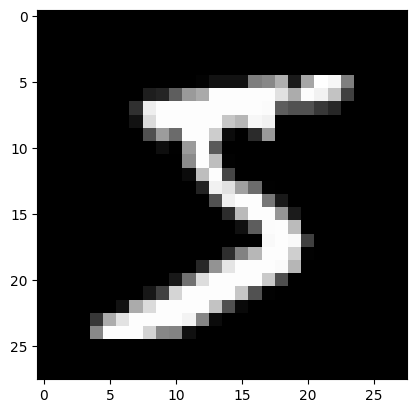

In [ ]:
image,label = dataset[0]
plt.imshow(image.permute(1,2,0),cmap='gray')
print(label)

Train and Validation Datasets


In [ ]:
val_size = 10000
train_size = len(dataset)-val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)


(50000, 10000)

In [ ]:
batch_size = 128
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size*2,shuffle=True,num_workers=2,pin_memory=True)

image_Shape:> torch.Size([128, 1, 28, 28])


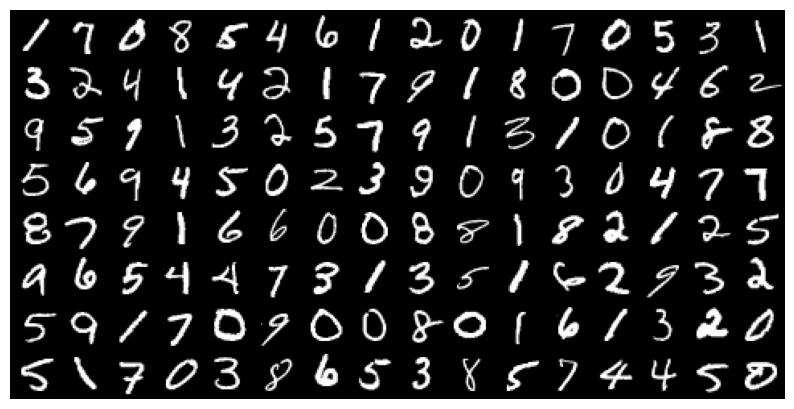

In [ ]:
for images,labels in train_dl:
  print('image_Shape:>',images.shape)
  plt.figure(figsize=(10,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
  break

In [ ]:
for images,labels in train_dl:
  print('images.shape:',images.shape)
  inputs = images.reshape(-1,784)
  print('inputs.shape',inputs.shape)
  break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape torch.Size([128, 784])


In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32

In [ ]:
layer1=nn.Linear(input_size,hidden_size)

In [ ]:
layer1_outputs = layer1(inputs)
print(layer1_outputs.shape)

torch.Size([128, 32])


In [ ]:
hidden_layer_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs:',torch.min(layer1_outputs).item())
print('min(hidden_layer_outputs:',torch.min(hidden_layer_outputs).item())

min(layer1_outputs: -0.8771611452102661
min(hidden_layer_outputs: 0.0


In [ ]:
output_size = 10
layer2=nn.Linear(hidden_size,output_size)

In [ ]:
layer2_outputs=layer2(hidden_layer_outputs)
layer2_outputs.shape

torch.Size([128, 10])

In [ ]:
inputs.shape

torch.Size([128, 784])

In [ ]:
F.cross_entropy(layer2_outputs,labels)

tensor(2.3112, grad_fn=<NllLossBackward0>)

## ***Model***

In [ ]:
class Mnist_nn(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super().__init__()
    self.layer1 = nn.Linear(input_size,hidden_size)
    self.layer2 = nn.Linear(hidden_size,output_size)
  def forward(self,xb):
    xb = xb.view(xb.size(0),-1)
    out = self.layer1(xb)
    out = F.relu(out)
    out = self.layer2(out)
    return out
  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  def validation_step(self,batch):
    images,labels =batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss, 'val_acc':acc}
  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return{'epoch_loss':epoch_loss,'epoch_acc':epoch_acc}
  def epoch_end(self, epoch, result):
      print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['epoch_loss'], result['epoch_acc']))


In [ ]:
def evaluate(model,val_dl):
  outputs = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(outputs)

In [ ]:
def accuracy(outputs,labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
model = Mnist_nn(input_size=784,hidden_size=52,output_size=10)

In [ ]:
for batch in train_dl:
  images,labels = batch
  outputs = model(images)
  loss = F.cross_entropy(outputs,labels)
  acc = accuracy(outputs,labels)
  print(loss,acc)
  break


tensor(2.2951, grad_fn=<NllLossBackward0>) tensor(0.0938)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
for xb, yb in val_dl:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([9, 1, 0, 9, 4, 8, 1, 8, 7, 7, 0, 9, 7, 1, 4, 2, 4, 2, 9, 6, 9, 7, 8, 8,
        5, 5, 9, 8, 1, 7, 4, 4, 0, 8, 9, 4, 1, 8, 2, 8, 5, 4, 0, 1, 6, 0, 9, 0,
        7, 4, 9, 4, 4, 5, 5, 7, 8, 0, 6, 1, 7, 3, 4, 7, 4, 5, 1, 9, 9, 2, 1, 2,
        2, 0, 5, 9, 2, 9, 7, 5, 3, 1, 0, 0, 9, 6, 6, 6, 6, 4, 2, 2, 0, 6, 2, 1,
        2, 1, 0, 8, 3, 5, 5, 6, 6, 5, 5, 7, 1, 6, 7, 2, 9, 2, 6, 8, 4, 3, 5, 3,
        0, 6, 0, 5, 1, 1, 9, 5, 0, 7, 1, 8, 5, 5, 2, 1, 5, 3, 8, 6, 1, 5, 5, 4,
        3, 2, 8, 8, 7, 2, 7, 8, 8, 0, 9, 7, 2, 2, 3, 8, 8, 8, 5, 0, 9, 1, 5, 8,
        8, 4, 5, 4, 8, 9, 8, 3, 0, 2, 3, 4, 9, 7, 7, 7, 8, 1, 5, 0, 0, 9, 9, 2,
        0, 1, 9, 1, 5, 6, 3, 3, 8, 1, 6, 2, 7, 0, 0, 1, 0, 8, 6, 3, 7, 7, 5, 1,
        1, 7, 1, 0, 1, 1, 8, 4, 1, 4, 9, 8, 9, 0, 7, 5, 8, 7, 1, 6, 9, 5, 9, 4,
        9, 8, 8, 5, 6, 3, 6, 7, 6, 8, 4, 9, 7, 8, 9, 5], device='cuda:0')


In [ ]:
def fit(model,train_dl,val_dl,lr,epochs,opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(),lr)
  history = []
  for epoch in range(epochs):
    for batch in train_dl:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model,val_dl)
    model.epoch_end(epoch,result)
    history.append(result)
  return history


In [ ]:
to_device(model, device)

Mnist_nn(
  (layer1): Linear(in_features=784, out_features=52, bias=True)
  (layer2): Linear(in_features=52, out_features=10, bias=True)
)

In [ ]:
for i in model.parameters():
  print(i.shape)

torch.Size([52, 784])
torch.Size([52])
torch.Size([10, 52])
torch.Size([10])


In [ ]:
history = [evaluate(model, val_dl)]
history

[{'epoch_loss': tensor(2.3081, device='cuda:0', grad_fn=<MeanBackward0>),
  'epoch_acc': tensor(0.0849)}]

In [ ]:
history += fit( model, train_dl, val_dl,lr=0.5,epochs=5)

Epoch [0], val_loss: 0.2107, val_acc: 0.9376
Epoch [1], val_loss: 0.1867, val_acc: 0.9426
Epoch [2], val_loss: 0.1371, val_acc: 0.9605
Epoch [3], val_loss: 0.1392, val_acc: 0.9584
Epoch [4], val_loss: 0.1214, val_acc: 0.9655


In [ ]:
history += fit( model, train_dl, val_dl,lr=0.5,epochs=5)

Epoch [0], val_loss: 0.1387, val_acc: 0.9616
Epoch [1], val_loss: 0.1124, val_acc: 0.9664
Epoch [2], val_loss: 0.1031, val_acc: 0.9701
Epoch [3], val_loss: 0.1078, val_acc: 0.9708
Epoch [4], val_loss: 0.1037, val_acc: 0.9705


In [ ]:
history += fit( model, train_dl, val_dl,lr=0.5,epochs=5)

Epoch [0], val_loss: 0.1097, val_acc: 0.9684
Epoch [1], val_loss: 0.1078, val_acc: 0.9701
Epoch [2], val_loss: 0.1055, val_acc: 0.9712
Epoch [3], val_loss: 0.1025, val_acc: 0.9713
Epoch [4], val_loss: 0.1068, val_acc: 0.9709


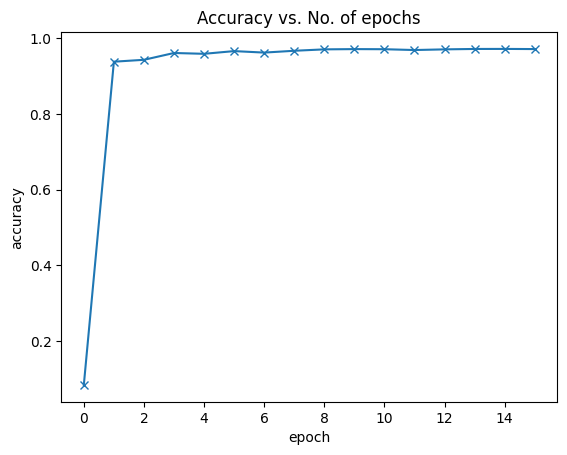

In [ ]:
accuracies = [x['epoch_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');